<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/u%2FEiffL%2Foptimization/nb/Optimized_HOD_HMC_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling HOD parameters by Hamiltonian Monte-Carlo

Authors:
 - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)
 - [@EiffL](https://github.com/EiffL) (Francois Lanusse)


This notebook demonstrate sampling HOD parameters using HMC over a stochastically sampled galaxy catalogs.




## Setup

Here we quickly install our dependencies, and download the reference halotools 
catalog from the Bolshoi simulation. This takes under a minute.

!pip install --quiet -i https://test.pypi.org/simple/ halotools
!pip install --quiet corner
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git@u/EiffL/optimization

!download_initial_halocat.py

In [2]:
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [3]:
import scipy

In [4]:
!nvidia-smi

Thu Sep 30 03:24:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   29C    P8     1W / 250W |     17MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 16%   

In [5]:
%pylab inline
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib


In [6]:
import tensorflow_probability as tfp
import tensorflow as tf


In [7]:
tfp.__version__, tf.__version__

('0.13.0', '2.6.0')

In [8]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

2021-09-30 03:24:12.306979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 03:24:13.797664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:20:00.0, compute capability: 7.0


In [9]:
import halotools

In [10]:
import numpy as np

In [11]:
np.__version__

'1.20.3'

In [12]:
import tensorflow as tf

tf.__version__,tf.__path__

('2.6.0',
 ['/home/ben.horowitz/miniconda3/envs/tf26/lib/python3.9/site-packages/keras/api/_v2',
  '/home/ben.horowitz/miniconda3/envs/tf26/lib/python3.9/site-packages/tensorflow_estimator/python/estimator/api/_v2',
  '/home/ben.horowitz/miniconda3/envs/tf26/lib/python3.9/site-packages/tensorboard/summary/_tf',
  '/home/ben.horowitz/miniconda3/envs/tf26/lib/python3.9/site-packages/tensorflow',
  '/home/ben.horowitz/miniconda3/envs/tf26/lib/python3.9/site-packages/tensorflow/_api/v2'])

In [274]:
# A few hyper parameters
temperature=0.02
batch_size=5
box_size = 128

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

In [275]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [276]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [277]:

#TF2 compatable painter
@tf.function  #(experimental_relax_shapes=True)
def cic_paint(mesh, part, weight=None, name="CiCPaint"):
  """
  Paints particules on a 3D mesh.
  Parameters:
  -----------
  mesh: tensor (batch_size, nc, nc, nc)
    Input 3D mesh tensor
  part: tensor (batch_size, npart, 3)
    List of 3D particle coordinates, assumed to be in mesh units if
    boxsize is None
  weight: tensor (batch_size, npart)
    List of weights  for each particle
  """
  with tf.name_scope(name):
    mesh = tf.convert_to_tensor(mesh, name="mesh")
    part = tf.convert_to_tensor(part, name="part")
    if weight is not None:
      weight = tf.convert_to_tensor(weight, name="weight")

    shape = tf.shape(mesh)
    batch_size, nx, ny, nz = shape[0], shape[1], shape[2], shape[3]
    nc = nz

    # Flatten part if it's not already done
    if len(part.shape) > 3:
      part = tf.reshape(part, (batch_size, -1, 3))

    # Extract the indices of all the mesh points affected by each particles
    part = tf.expand_dims(part, 2)
    floor = tf.floor(part)
    connection = tf.expand_dims(
        tf.constant([[[0, 0, 0], [1., 0, 0], [0., 1, 0], [0., 0, 1], [1., 1, 0],
                      [1., 0, 1], [0., 1, 1], [1., 1, 1]]]), 0)

    neighboor_coords = floor + connection
    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]

    if weight is not None:
      kernel = tf.multiply(tf.expand_dims(weight, axis=-1), kernel)

    # Adding batch dimension to the neighboor coordinates
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
    b = tf.tile(batch_idx, [1] + list(neighboor_coords.get_shape()[1:-1]) + [1])
    b = tf.cast(b, tf.float32)
    neighboor_coords = tf.concat([b, neighboor_coords], axis=-1)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.math.mod(neighboor_coords, nc)

    update = tf.scatter_nd(
        tf.reshape(neighboor_coords, (-1, 8, 4)), tf.reshape(kernel, (-1, 8)),
        [batch_size, nx, ny, nz])
    mesh = mesh + update
    return mesh

Total size of halo catalog 139905
Size of low mass halo catalog 139797
Size of high mass halo catalog 108


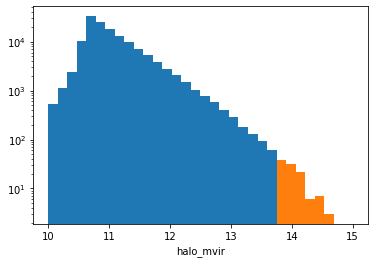

In [278]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
print("Total size of halo catalog", len(halo_table))

# Split the catalog into low and high mass halo
low_mass_table = halo_table[np.log10(halo_table['halo_mvir']) < 13.75]
high_mass_table = halo_table[np.log10(halo_table['halo_mvir']) >= 13.75]

# Convert table to tensors
tf_halocat_low = {k: tf.convert_to_tensor(low_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}
tf_halocat_high = {k: tf.convert_to_tensor(high_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}

hist(log10(low_mass_table['halo_mvir']),32, range=[10,15]);
hist(log10(high_mass_table['halo_mvir']),32, range=[10,15]);
yscale('log')
xlabel('halo_mvir');
print("Size of low mass halo catalog", len(low_mass_table))
print("Size of high mass halo catalog", len(high_mass_table));

In [279]:
# Here is how we define the same model in
def hod(halo_cat, 
        logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
        max_sat=20):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature)
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                       halo_cat['halo_y'],
                                       halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [280]:
def paint_galaxies(gal_cat, nc=128, rho=None):
  """ Function that paints galaxies on the field
  """
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  if rho is None:
    rho = tf.zeros((bs, nc, nc, nc))

  rho = cic_paint(rho,sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)
  return rho

In [281]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
           max_sat_low=20, max_sat_high=100):
  """ This function samples the catalogs, paint the galaxies, and compute the 
  power spectrum
  """
  # Sample and paint galaxies low mass halos
  rho = paint_galaxies(hod(tf_halocat_low, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_low))
  
  # Add galaxies from high mass halos
  rho = paint_galaxies(hod(tf_halocat_high, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_high),
                       rho=rho)
  
  # Compute power spectrum of resulting field
  k, pk = PS.pk_tf(rho)
  return k[:20], pk[:,:20]

In [282]:
tf.test.is_gpu_available()

2021-10-05 00:55:27.881191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:20:00.0, compute capability: 7.0


True

In [283]:
get_pk(logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475, 0.525,
        0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925, 0.975,
        1.025, 1.075])>,
 <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0.09239969, 0.07613208, 0.05506777, 0.04414453, 0.03644345,
         0.02975124, 0.0239155 , 0.02403635, 0.01908424, 0.01835261,
         0.01658778, 0.01601791, 0.01577527, 0.01317449, 0.01319651,
         0.01217239, 0.0116121 , 0.0111762 , 0.01073486, 0.01037942],
        [0.08969005, 0.07908186, 0.05631683, 0.04457672, 0.03705875,
         0.03003673, 0.02290647, 0.02410732, 0.01965553, 0.01871306,
         0.01699234, 0.01635266, 0.01574885, 0.01373844, 0.01338021,
         0.01251833, 0.01213373, 0.01135337, 0.01084584, 0.01076055],
        [0.09054004, 0.07502786, 0.05647041, 0.04171414, 0.0375086 ,
         0.0294399 , 0.02312128, 0.02253057, 0.01988985, 0.01887263,
         0.017074  , 0.01588453, 0.0158879 

In [24]:
# Let's just compute a diagonal cov (takes a while...)
import time
start_time = time.time()
samps = []
for i in range(1000):
    print(i)
    k, pk = get_pk(logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))
    samps.append(pk)
end_time = time.time()- start_time
print(end_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
samps = np.stack(samps, axis=0).reshape(2000,-1)
np.save("samps_cov",samps)

In [26]:
import scipy

In [27]:
diag_std = samps.std(axis=0)
mean = samps.mean(axis=0)

In [28]:
samps.shape

(2000, 20)

 ...]

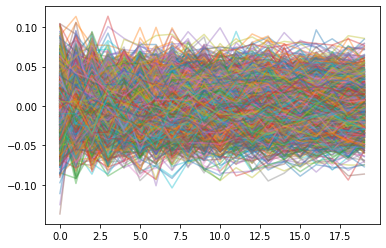

In [29]:
plt.plot(((samps-mean)/mean).T,alpha=0.40)


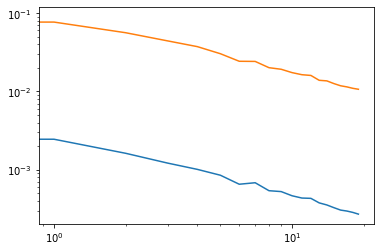

In [30]:
loglog(diag_std)
loglog(mean)

In [31]:
cov = np.array(np.cov(samps.T),dtype=np.float32)

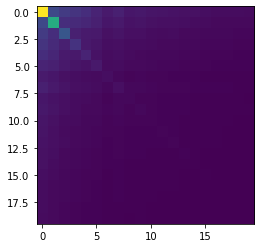

In [32]:
imshow(cov)

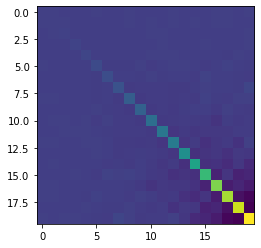

In [33]:
imshow(np.linalg.inv(cov))

In [34]:
k

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475, 0.525,
       0.575, 0.625, 0.675, 0.725, 0.775, 0.825, 0.875, 0.925, 0.975,
       1.025, 1.075])>

In [35]:
mean = mean[:20]

In [36]:
cov_cut = cov[:20,:20]

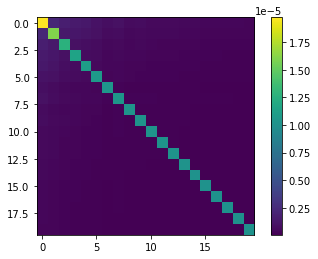

In [43]:
imshow(cov_cut+np.eye(20)*10**(-5))
colorbar()

In [235]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
           max_sat_low=20, max_sat_high=100):
  """ This function samples the catalogs, paint the galaxies, and compute the 
  power spectrum
  """
  # Sample and paint galaxies low mass halos
  rho = paint_galaxies(hod(tf_halocat_low, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_low))
  
  # Add galaxies from high mass halos
  rho = paint_galaxies(hod(tf_halocat_high, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_high),
                       rho=rho)
  
  # Compute power spectrum of resulting field
  k, pk = PS.pk_tf(rho)
  return k[:20], pk[:,:20]

In [236]:
# This is not the right way to do this with edward, but...
import tensorflow_probability as tfp 
tfd = tfp.distributions

p = tf.tile(tf.expand_dims(fid_params,0), [batch_size, 1])
cov_use = np.array(cov_cut+1*np.eye(20)*10**(-5),dtype=np.float32)
def log_prob_fn(params):
  k, pk = get_pk(logMmin=params[:,0],
              sigma_logM=params[:,1], 
              logM0=params[:,2], 
              logM1=params[:,3], 
              alpha=params[:,4])
  return tfp.distributions.MultivariateNormalFullCovariance(loc=mean,covariance_matrix=cov_use).log_prob(pk)#tfd.MultivariateNormalDiag(loc=mean,scale_diag=diag_std).log_prob(pk)/25
      
      

In [237]:
fid_params

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([12.02,  0.26, 11.38, 13.31,  1.06], dtype=float32)>

In [238]:
fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])
p = tf.tile(tf.expand_dims(fid_params,0), [batch_size, 1])
k, pk = get_pk(logMmin=p[:,0],
              sigma_logM=p[:,1], 
              logM0=p[:,2], 
              logM1=p[:,3], 
              alpha=p[:,4])
#print(tfd.MultivariateNormalDiag(loc=mean,scale_diag=diag_std).log_prob(pk))#tfp.distributions.MultivariateNormalFullCovariance(loc=mean,covariance_matrix=cov).log_prob(pk))#
#

In [240]:
pk

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0.09310977, 0.07468503, 0.05384044, 0.04459482, 0.03642897,
        0.03018273, 0.02450009, 0.02359781, 0.02059395, 0.0192337 ,
        0.01708205, 0.01633673, 0.01577247, 0.01359796, 0.0138267 ,
        0.01247434, 0.0119769 , 0.01160965, 0.010966  , 0.01066219],
       [0.08908338, 0.07862452, 0.05400661, 0.04377414, 0.03620546,
        0.0300088 , 0.02445331, 0.0238765 , 0.0202065 , 0.01924512,
        0.01782807, 0.01635445, 0.01583447, 0.01392122, 0.01363375,
        0.01257877, 0.0118726 , 0.0115905 , 0.01099272, 0.01065957],
       [0.08851913, 0.08080653, 0.05775601, 0.04477184, 0.03925898,
        0.03078307, 0.02510794, 0.02565843, 0.02109714, 0.02035156,
        0.01771742, 0.01698757, 0.01615415, 0.01443291, 0.01412074,
        0.01307126, 0.01236256, 0.01184923, 0.01130426, 0.0110043 ],
       [0.08949028, 0.07848017, 0.05688583, 0.04433956, 0.03686019,
        0.0303263 , 0.02373644, 0.02397169, 0.02031085, 0.01920

In [241]:
print(tfp.distributions.MultivariateNormalFullCovariance(loc=mean[:20],covariance_matrix=cov[:20,:20]).log_prob(mean[:20]))#tfd.MultivariateNormalDiag(loc=mean,scale_diag=diag_std).log_prob(pk)/25


tf.Tensor(139.99704, shape=(), dtype=float32)


In [284]:
#num_burnin_steps = int(1e1) #oops....
num_chains = batch_size

#tfp.mcmc.SimpleStepSizeAdaptation(
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        num_leapfrog_steps=5,
        step_size=1e-2)#, #can play a lot with this number...
#    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [285]:
#start spread out around some point
var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.02,0.01,0.1,0.01])*1

In [287]:
num_results = 10000

# Initial state of the chain
init_state = tf.Variable(np.ones([num_chains, 5], dtype=dtype)*fid_params+var,dtype=float32)

In [288]:
log_prob_fn(init_state)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([87.56088 , 95.7609  , 85.2053  , 87.52241 , 95.149574],
      dtype=float32)>

In [289]:
@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, trace = tfp.mcmc.sample_chain(
      num_results=num_results,
      #num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc)
#      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples, trace

In [ ]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

/home/ben.horowitz/.local/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [260]:
print(run_time/60/60)

10.295196359025107


In [261]:
is_accepted.is_accepted

<tf.Tensor: shape=(10000, 5), dtype=bool, numpy=
array([[ True,  True, False, False, False],
       [False, False,  True,  True,  True],
       [ True,  True,  True,  True, False],
       ...,
       [ True, False, False, False, False],
       [ True, False, False,  True, False],
       [ True, False,  True,  True, False]])>

In [262]:
init_state

<tf.Variable 'Variable:0' shape=(10, 5) dtype=float32, numpy=
array([[12.036935  ,  0.26567915, 11.378458  , 13.279572  ,  1.0634967 ],
       [12.0584    ,  0.25991932, 11.382779  , 13.287326  ,  1.0630199 ],
       [12.018493  ,  0.26546985, 11.375442  , 13.302485  ,  1.0588729 ],
       [12.062592  ,  0.25059506, 11.376878  , 13.312222  ,  1.0635437 ],
       [12.038905  ,  0.25986293, 11.381057  , 13.264563  ,  1.062615  ],
       [11.98857   ,  0.26919833, 11.376919  , 13.3304615 ,  1.0559306 ],
       [12.023276  ,  0.2624784 , 11.384045  , 13.336804  ,  1.0558606 ],
       [12.04108   ,  0.2683672 , 11.384263  , 13.260154  ,  1.0571071 ],
       [12.050076  ,  0.25442323, 11.379274  , 13.345869  ,  1.0563551 ],
       [11.988231  ,  0.26607051, 11.383319  , 13.332755  ,  1.0552106 ]],
      dtype=float32)>

In [263]:
q.shape

TensorShape([10000, 5, 5])

In [264]:
q-init_state

2021-10-05 00:48:39.460407: W tensorflow/core/framework/op_kernel.cc:1680] Invalid argument: required broadcastable shapes


InvalidArgumentError: required broadcastable shapes [Op:Sub]

In [265]:
import corner

In [266]:
is_accepted

MetropolisHastingsKernelResults(
  accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction=<tf.Tensor: shape=(10000, 5), dtype=float32, numpy=
        array([[-1.1443582 ,  0.0895654 ,  0.        ,  0.        ,  0.        ],
               [-1.1443582 ,  0.0895654 ,  0.39737916, -0.61319995,  0.5166476 ],
               [-0.05877316, -0.05934644,  0.22460806, -1.6745999 ,  0.5166476 ],
               ...,
               [ 1.6314476 ,  0.5438838 ,  1.198585  ,  0.28113222, -2.1065695 ],
               [-0.14416575,  0.5438838 ,  1.198585  ,  0.88172054, -2.1065695 ],
               [-0.47855353,  0.5438838 ,  0.58769035,  0.06035775, -2.1065695 ]],
              dtype=float32)>,
      target_log_prob=<tf.Tensor: shape=(10000, 5), dtype=float32, numpy=
        array([[95.31237 , 93.247215, 95.161896, 87.173935, 91.020004],
               [95.31237 , 93.247215, 95.17656 , 85.92343 , 93.79401 ],
               [94.31261 , 94.03542 , 95.34245 , 87.98

In [267]:
q.shape

TensorShape([10000, 5, 5])

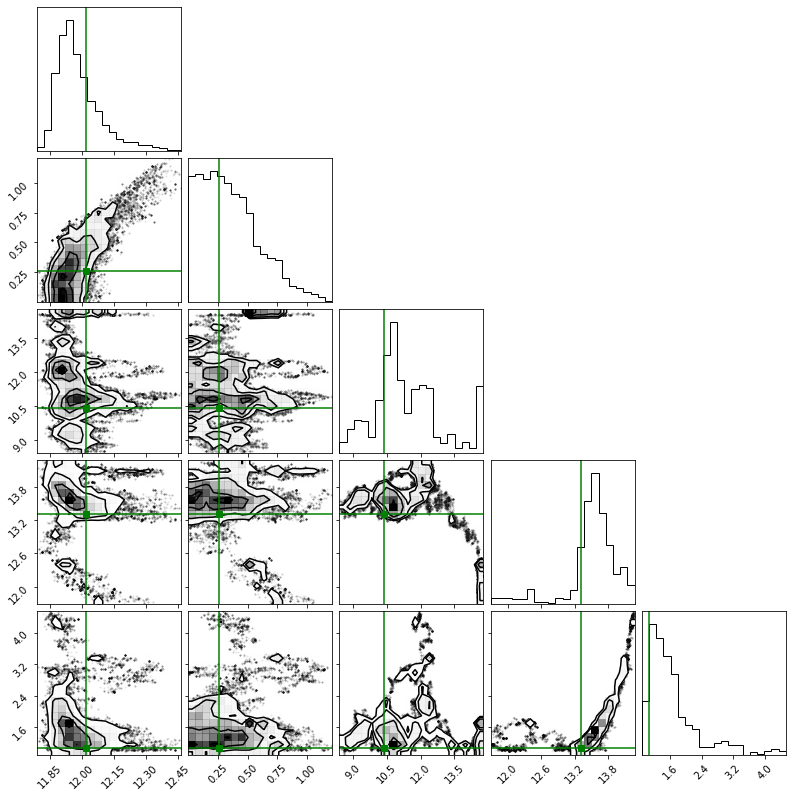

In [273]:
figure = corner.corner(np.array(q[1000:,:,:]).reshape(-1,5)[:]);
value1 = [12.02, 0.26, 10.38,13.31, 1.06]
ndim = 5
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")
        ax.plot(value1[xi], value1[yi], "sg")